In [46]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# File paths
file_path = '../formatted_data/formatted_data.csv'

# Define input and output sequence lengths
sequence_length = 336  # Use 2 weeks of history
output_sequence_length = 24  # Predict the next 24 hours
batch_size = 32
test_split_ratio = 0.2

# Load the data
data = pd.read_csv(file_path)

start_date = "2023-01-01"
end_date = "2024-06-30"

# Convert to datetime for filtering
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

# Drop the `Date` column after filtering (if not needed further)
data = data.drop(columns=['Date'])

# Confirm the data is clean
print("### Data Integrity Check After Cleaning ###")
print(data.isna().sum().sum())  # Should be 0

# Initialize a scaler for all features
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale all features (including time-based features that are already 0-1)
features_scaled = scaler.fit_transform(data)

# Prepare sequences for input and target
X, y = [], []

for i in range(len(features_scaled) - sequence_length - output_sequence_length):
    # Input sequence: past `sequence_length` steps
    X.append(features_scaled[i:i + sequence_length])  
    # Target sequence: next `output_sequence_length` steps
    y.append(features_scaled[i + sequence_length:i + sequence_length + output_sequence_length, -1])  # Assuming target is in the last column

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Train-test split
split_idx = int(len(X) * (1 - test_split_ratio))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Confirm shapes and integrity
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"X_train has NaN: {torch.isnan(X_train).any()}, Inf: {torch.isinf(X_train).any()}")
print(f"y_train has NaN: {torch.isnan(y_train).any()}, Inf: {torch.isinf(y_train).any()}")

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


### Data Integrity Check After Cleaning ###
0
Training data shape: torch.Size([11490, 336, 22])
Test data shape: torch.Size([1277, 336, 22])
X_train has NaN: False, Inf: False
y_train has NaN: False, Inf: False
Training data shape: torch.Size([11490, 336, 22])
Test data shape: torch.Size([1277, 336, 22])


In [47]:
    
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMModelWithSpread(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.1):
        super(LSTMModelWithSpread, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc_median = nn.Linear(hidden_size, output_size)  # Median predictions
        self.fc_spread = nn.Linear(hidden_size, output_size)  # Spread predictions (positive values)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_last_hidden = lstm_out[:, -1, :]  # Use the last hidden state
        median = self.fc_median(lstm_last_hidden)  # Median prediction
        spread = torch.abs(self.fc_spread(lstm_last_hidden))  # Ensure positive spread
        return median, spread

    
def quantile_loss(y_true, y_pred, quantile):
    errors = y_true - y_pred
    return torch.mean(torch.maximum(quantile * errors, (quantile - 1) * errors))
  
def quantile_loss_v2(y_true, median, spread, quantile=0.1, spread_penalty=0.01):
    """
    Compute quantile loss for central predictions and spread regularization.

    Args:
        y_true: Ground truth values.
        median: Predicted median values.
        spread: Predicted spread (confidence interval).
        quantile: Desired quantile (e.g., 0.1 for 90% interval).
        spread_penalty: Penalty term to reduce spread.

    Returns:
        Total loss.
    """
    lower_bound = median - spread  # Lower bound of prediction interval
    upper_bound = median + spread  # Upper bound of prediction interval

    # Compute quantile losses
    lower_loss = torch.maximum((y_true - lower_bound) * quantile, (lower_bound - y_true) * (1 - quantile))
    upper_loss = torch.maximum((upper_bound - y_true) * quantile, (y_true - upper_bound) * (1 - quantile))

    quantile_loss = torch.mean(lower_loss + upper_loss)

    # Penalize large spreads to encourage tighter intervals
    spread_regularization = spread_penalty * torch.mean(spread)

    return quantile_loss + spread_regularization


def quantile_loss_with_spread(y_true, central, spread, quantile=0.1, reg_factor=0.01):
    """
    Quantile loss using central prediction and spread.

    Args:
        y_true: Ground truth values [batch_size, forecast_horizon].
        central: Central predictions [batch_size, forecast_horizon].
        spread: Spread predictions (positive) [batch_size, forecast_horizon].
        quantile: Desired quantile level (e.g., 0.1 for 90% interval).
        reg_factor: Regularization factor for the spread.

    Returns:
        Total loss combining quantile loss and regularization.
    """
    lower_bound = central - spread  # Lower quantile bound
    upper_bound = central + spread  # Upper quantile bound

    # Quantile loss components
    lower_errors = y_true - lower_bound
    upper_errors = upper_bound - y_true

    quantile_loss = torch.mean(torch.maximum((quantile) * lower_errors, (quantile - 1) * lower_errors)) + \
                    torch.mean(torch.maximum((1 - quantile) * upper_errors, (quantile - 1) * upper_errors))

    # Regularization for tight bounds
    reg_loss = reg_factor * torch.mean(spread**2)

    return quantile_loss + reg_loss

def simplified_symmetric_loss(y_true, central, spread, reg_factor=0.01):
    """
    Symmetric loss using absolute errors and spread as a confidence measure.

    Args:
        y_true: Ground truth values [batch_size, forecast_horizon].
        central: Central predictions (median) [batch_size, forecast_horizon].
        spread: Spread predictions (positive) [batch_size, forecast_horizon].
        reg_factor: Regularization factor for spread to avoid overconfidence.

    Returns:
        Total loss combining scaled error and spread regularization.
    """
    # Ensure spread is positive and stable
    spread = torch.clamp(spread, min=1e-6)

    # Symmetric loss: Scale absolute error by spread (spread acts like uncertainty)
    error = torch.abs(y_true - central)
    scaled_loss = torch.mean(error / spread)

    # Regularization to avoid spread collapsing to zero
    reg_loss = reg_factor * torch.mean(spread**2)

    return scaled_loss + reg_loss


def precise_symmetric_loss(y_true, central, spread, reg_factor=0.01, spread_penalty=0.1, epsilon=1e-6):
    """
    Symmetric loss with explicit penalty for large spreads.

    Args:
        y_true: Ground truth values [batch_size, forecast_horizon].
        central: Central predictions (median) [batch_size, forecast_horizon].
        spread: Spread predictions (positive) [batch_size, forecast_horizon].
        reg_factor: Regularization factor for spread regularization.
        spread_penalty: Additional penalty for spread size.
        epsilon: Small constant to prevent division by zero.

    Returns:
        Total loss combining scaled error and spread regularization.
    """
    # Ensure spread is positive and prevent division by zero
    spread = torch.clamp(spread, min=epsilon)

    # Scaled absolute error (error inversely proportional to spread)
    error = torch.abs(y_true - central)
    scaled_loss = torch.mean(error / spread)

    # Exponential penalty for large spreads
    spread_loss = spread_penalty * torch.mean(torch.exp(spread))

    # Regularization for stable spread values
    reg_loss = reg_factor * torch.mean(spread**2)

    return scaled_loss + spread_loss + reg_loss




In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 64  # LSTM hidden size
output_size = y_train.shape[1]  # Prediction horizon (24 hours)
num_layers = 2
dropout = 0.1
epochs = 20
batch_size = 32
learning_rate = 0.001
quantile = 0.1  # For 90% prediction interval
spread_penalty = 0.01  # Penalty term for spread regularization

# Initialize the model
model = LSTMModelWithSpread(input_size, hidden_size, output_size, num_layers, dropout).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
best_val_loss = float('inf')  # Track the best validation loss
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        median_preds, spread_preds = model(X_batch)
        loss = quantile_loss_v2(y_batch, median_preds, spread_preds, quantile=quantile, spread_penalty=spread_penalty)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        median_preds, spread_preds = model(X_test.to(device))
        val_loss = quantile_loss_v2(y_test.to(device), median_preds, spread_preds, quantile=quantile, spread_penalty=spread_penalty).item()

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss / len(train_loader):.6f}, Val Loss: {val_loss:.6f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_quantile_model.pth")

print("Training complete.")


Epoch [1/20], Train Loss: 0.037659, Val Loss: 0.039030
Epoch [2/20], Train Loss: 0.025892, Val Loss: 0.035456
Epoch [3/20], Train Loss: 0.025395, Val Loss: 0.034885
Epoch [4/20], Train Loss: 0.024936, Val Loss: 0.035673
Epoch [5/20], Train Loss: 0.024495, Val Loss: 0.036611
Epoch [6/20], Train Loss: 0.024121, Val Loss: 0.035697
Epoch [7/20], Train Loss: 0.023807, Val Loss: 0.037169
Epoch [8/20], Train Loss: 0.023447, Val Loss: 0.037657
Epoch [9/20], Train Loss: 0.023098, Val Loss: 0.037090
Epoch [10/20], Train Loss: 0.022745, Val Loss: 0.036700
Epoch [11/20], Train Loss: 0.022397, Val Loss: 0.038044
Epoch [12/20], Train Loss: 0.022012, Val Loss: 0.038192
Epoch [13/20], Train Loss: 0.021712, Val Loss: 0.036133
Epoch [14/20], Train Loss: 0.021273, Val Loss: 0.036713
Epoch [15/20], Train Loss: 0.020858, Val Loss: 0.035390
Epoch [16/20], Train Loss: 0.020334, Val Loss: 0.037111
Epoch [17/20], Train Loss: 0.020059, Val Loss: 0.037724
Epoch [18/20], Train Loss: 0.019371, Val Loss: 0.039418
E

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test data
model.eval()
with torch.no_grad():
    median_preds, spread_preds = model(X_test.to(device))
    median_preds_rescaled = scaler_target.inverse_transform(median_preds.cpu().numpy())
    spread_preds_rescaled = scaler_target.inverse_transform(spread_preds.cpu().numpy())
    y_test_rescaled = scaler_target.inverse_transform(y_test.cpu().numpy())

# Calculate lower and upper bounds
lower_bounds = median_preds_rescaled - spread_preds_rescaled
upper_bounds = median_preds_rescaled + spread_preds_rescaled

# Metrics Calculation
rmse_per_sample = []
mape_per_sample = []
r2_per_sample = []
quantile_coverage = []

for actual, median, lower, upper in zip(y_test_rescaled, median_preds_rescaled, lower_bounds, upper_bounds):
    rmse = np.sqrt(mean_squared_error(actual, median))
    mape = np.mean(np.abs((actual - median) / actual)) * 100
    r2 = r2_score(actual, median)
    coverage = np.mean((actual >= lower) & (actual <= upper)) * 100

    rmse_per_sample.append(rmse)
    mape_per_sample.append(mape)
    r2_per_sample.append(r2)
    quantile_coverage.append(coverage)

# Find indices for best, median, and worst performance based on RMSE
sorted_indices = np.argsort(rmse_per_sample)
best_indices = sorted_indices[:3]
worst_indices = sorted_indices[-3:]
median_indices = sorted_indices[len(sorted_indices) // 2 - 1:len(sorted_indices) // 2 + 2]

# Function to visualize predictions and bounds
def plot_quantile_predictions(index, title):
    actual = y_test_rescaled[index]
    median = median_preds_rescaled[index]
    spread = spread_preds_rescaled[index]
    lower_bound = lower_bounds[index]
    upper_bound = upper_bounds[index]

    plt.figure(figsize=(10, 5))
    plt.plot(actual, label="Actual Prices", color="blue")
    plt.plot(median, label="Median Prediction", color="red")
    plt.fill_between(range(len(actual)), lower_bound, upper_bound, color="gray", alpha=0.3, label="Prediction Interval")
    plt.title(title)
    plt.xlabel("Hour")
    plt.ylabel("Price (EUR/MWh)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize best, worst, and median performances
print("### Best Predictions ###")
for i, idx in enumerate(best_indices, 1):
    print(f"Best {i} - RMSE: {rmse_per_sample[idx]:.2f}, MAPE: {mape_per_sample[idx]:.2f}%, R²: {r2_per_sample[idx]:.2f}, Coverage: {quantile_coverage[idx]:.2f}%")
    plot_quantile_predictions(idx, f"Best {i} Performance: Predicted vs Actual")

print("\n### Worst Predictions ###")
for i, idx in enumerate(worst_indices, 1):
    print(f"Worst {i} - RMSE: {rmse_per_sample[idx]:.2f}, MAPE: {mape_per_sample[idx]:.2f}%, R²: {r2_per_sample[idx]:.2f}, Coverage: {quantile_coverage[idx]:.2f}%")
    plot_quantile_predictions(idx, f"Worst {i} Performance: Predicted vs Actual")

print("\n### Median Predictions ###")
for i, idx in enumerate(median_indices, 1):
    print(f"Median {i} - RMSE: {rmse_per_sample[idx]:.2f}, MAPE: {mape_per_sample[idx]:.2f}%, R²: {r2_per_sample[idx]:.2f}, Coverage: {quantile_coverage[idx]:.2f}%")
    plot_quantile_predictions(idx, f"Median {i} Performance: Predicted vs Actual")

# Summary statistics
print("\n### Metrics Summary ###")
print(f"Average RMSE: {np.mean(rmse_per_sample):.2f}")
print(f"Median RMSE: {np.median(rmse_per_sample):.2f}")
print(f"Average MAPE: {np.mean(mape_per_sample):.2f}%")
print(f"Median MAPE: {np.median(mape_per_sample):.2f}%")
print(f"Average R²: {np.mean(r2_per_sample):.2f}")
print(f"Median R²: {np.median(r2_per_sample):.2f}")
print(f"Average Coverage: {np.mean(quantile_coverage):.2f}%")
print(f"Median Coverage: {np.median(quantile_coverage):.2f}%")


NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [39]:
def objective(trial):
    # Hyperparameters to optimize
    quantile = trial.suggest_float("quantile", 0.01, 0.2)  # Confidence level
    reg_factor = trial.suggest_float("reg_factor", 1e-5, 1e-2, log=True)
    spread_penalty = trial.suggest_float("spread_penalty", 0.01, 0.5)

    # Initialize model
    model = LSTMModelWithSpread(
        input_size=X_train.shape[2],
        hidden_size=64,
        output_size=output_sequence_length,
        num_layers=2,
        dropout=0.1
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Move validation data to the same device as the model
    X_test_device = X_test.to(device)
    y_test_device = y_test.to(device)

    # Training Loop
    for epoch in range(50):  # Use fewer epochs for quick optimization
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            central_output, spread_output = model(X_batch)

            # Use the precise symmetric loss
            loss = precise_symmetric_loss(
                y_batch, central_output, spread_output,
                reg_factor=reg_factor,
                spread_penalty=spread_penalty
            )

            loss.backward()
            optimizer.step()

    # Validation Loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        central_output, spread_output = model(X_test_device)  # Use device tensors
        val_loss = precise_symmetric_loss(
            y_test_device, central_output, spread_output,
            reg_factor=reg_factor,
            spread_penalty=spread_penalty
        ).item()

    return val_loss


In [40]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)  # Run 30 trials

# Print best hyperparameters
print("Best Trial:")
print(study.best_trial.params)


[I 2024-12-16 16:55:41,825] A new study created in memory with name: no-name-0ed2200b-05dc-40b4-a56d-77f54bea80f3
[I 2024-12-16 16:56:28,011] Trial 0 finished with value: 0.5418283343315125 and parameters: {'quantile': 0.10846376478662367, 'reg_factor': 0.005352265170806069, 'spread_penalty': 0.48092192453913163}. Best is trial 0 with value: 0.5418283343315125.
[I 2024-12-16 16:57:12,812] Trial 1 finished with value: 0.4111942946910858 and parameters: {'quantile': 0.05014534877387543, 'reg_factor': 0.0006021408401021412, 'spread_penalty': 0.49281259837414454}. Best is trial 1 with value: 0.4111942946910858.
[I 2024-12-16 16:57:56,213] Trial 2 finished with value: 0.18374581634998322 and parameters: {'quantile': 0.08360205038876227, 'reg_factor': 0.0007354685726955535, 'spread_penalty': 0.10045299044697419}. Best is trial 2 with value: 0.18374581634998322.
[I 2024-12-16 16:58:40,386] Trial 3 finished with value: 0.33480072021484375 and parameters: {'quantile': 0.11534620838465698, 'reg_

Best Trial:
{'quantile': 0.16307290616561537, 'reg_factor': 0.004135307963268258, 'spread_penalty': 0.010093217171400352}


Epoch 1/500, Train Loss: 771.0149, Val Loss: 79301.4641
Epoch 2/500, Train Loss: 530.9592, Val Loss: 44.0049
Epoch 3/500, Train Loss: 244.1648, Val Loss: 59.6188
Epoch 4/500, Train Loss: 85.7341, Val Loss: 56.5544
Epoch 5/500, Train Loss: 38.4321, Val Loss: 28.2067
Epoch 6/500, Train Loss: 24.2554, Val Loss: 19.6127
Epoch 7/500, Train Loss: 18.4702, Val Loss: 15.7916
Epoch 8/500, Train Loss: 14.9529, Val Loss: 13.0474
Epoch 9/500, Train Loss: 12.7452, Val Loss: 11.3140
Epoch 10/500, Train Loss: 11.4562, Val Loss: 10.0187
Epoch 11/500, Train Loss: 10.0887, Val Loss: 9.2494
Epoch 12/500, Train Loss: 9.4562, Val Loss: 8.6991
Epoch 13/500, Train Loss: 8.8221, Val Loss: 8.1645
Epoch 14/500, Train Loss: 8.2969, Val Loss: 7.7741
Epoch 15/500, Train Loss: 7.9205, Val Loss: 7.3970
Epoch 16/500, Train Loss: 7.6941, Val Loss: 7.0817
Epoch 17/500, Train Loss: 7.2189, Val Loss: 6.8479
Epoch 18/500, Train Loss: 6.9713, Val Loss: 6.6471
Epoch 19/500, Train Loss: 6.8053, Val Loss: 6.4889
Epoch 20/500,

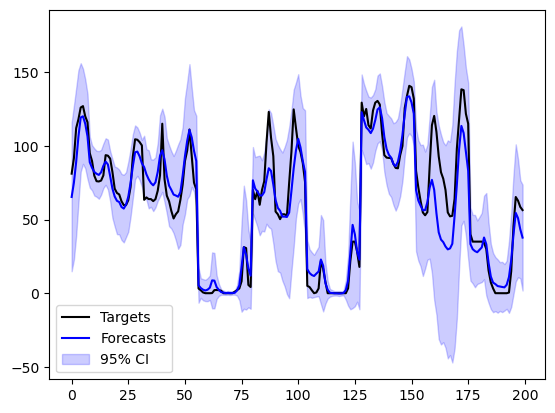

Root Mean Square Error (RMSE): 23.4489


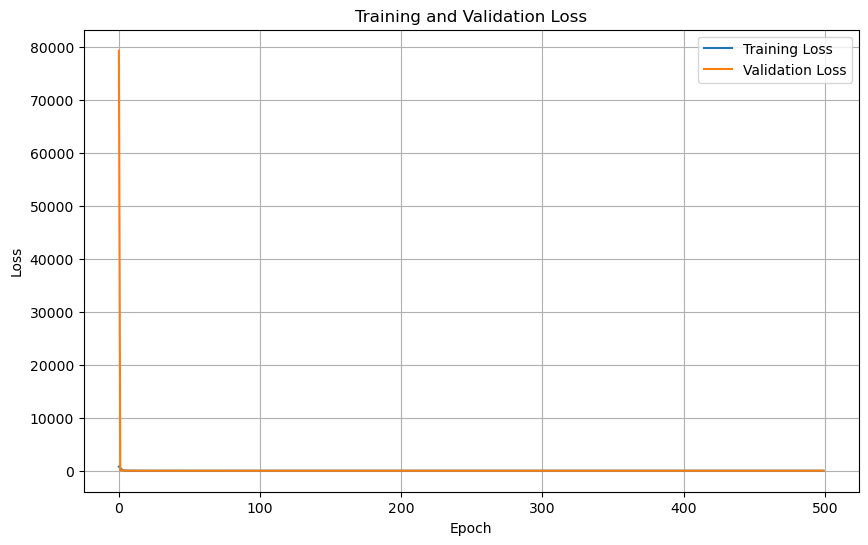

In [27]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load the data
data_spain = pd.read_csv(r'../formatted_data/formatted_data.csv')
data_spain['Weekday'] = pd.to_datetime(data_spain[['Year', 'Month', 'Day']]).dt.weekday

# Define the PyTorch Dataset class
class PricePredictionDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.X, self.Y = self.prepare_data()

    def prepare_data(self):
        df = self.data
        num_days = len(df) // 24

        # Output: DA prices
        Y = np.zeros((num_days, 24))
        for d in range(num_days):
            Y[d, :] = df.loc[df.index[d * 24:(d + 1) * 24], 'DA'].to_numpy()

        # Feature matrix
        X = np.zeros((num_days, len(df.columns) * 24))  # Adjust size to include all features
        for d in range(7, num_days):
            for i, col in enumerate(df.columns):
                X[d, i * 24:(i + 1) * 24] = df.loc[df.index[(d - 1) * 24:(d) * 24], col].to_numpy()

        # Final feature tensor (drop the first 7 days)
        X = X[7:, :]
        Y = Y[7:, :]


        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Define the PyTorch Model
class ProbNNModel(nn.Module):
    def __init__(self, input_size, output_size, distribution):
        super(ProbNNModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.distribution = distribution

        # Define layers
        self.batch_norm = nn.BatchNorm1d(input_size)
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)

        if distribution == 'Normal':
            self.fc4 = nn.Linear(128, output_size * 2)  # loc and scale
        else:
            raise NotImplementedError(f"Distribution {distribution} not implemented.")

    def forward(self, x):
        x = self.batch_norm(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)

        loc = x[:, :self.output_size]
        scale = 3e-3 + 3 * F.softplus(x[:, self.output_size:])
        return loc, scale

# Negative Log Likelihood loss for Normal distribution
class NegativeLogLikelihood(nn.Module):
    def __init__(self):
        super(NegativeLogLikelihood, self).__init__()

    def forward(self, loc, scale, target):
        # Ensure constants are tensors
        two_pi = torch.tensor(2.0 * np.pi, device=loc.device, dtype=loc.dtype)
        log_prob = -0.5 * (torch.log(two_pi) + torch.log(scale**2) + ((target - loc)**2) / (scale**2))
        return -torch.mean(log_prob)


# Training loop
def train_model(model, train_loader, val_loader, params):

    criterion = NegativeLogLikelihood()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    epochs = params.get('epochs', 400)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            loc, scale = model(inputs)
            loss = criterion(loc, scale, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, targets in val_loader:
                loc, scale = model(inputs)
                loss = criterion(loc, scale, targets)
                val_loss += loss.item()

        # Compute average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}")

    # Return the model and the loss lists
    return model, train_losses, val_losses


# Load and preprocess the dataset
dataset = PricePredictionDataset(data_spain)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the model
input_size = dataset.X.shape[1]
output_size = 24
model = ProbNNModel(input_size=input_size, output_size=output_size, distribution='Normal')

# Training parameters
params = {
    'learning_rate': 0.0001,
    'epochs': 500
}

# Train the model
model, train_losses, val_losses = train_model(model, train_loader, val_loader, params)

# Evaluate the model
model.eval()
forecasts, targets, scales = [], [], []
with torch.no_grad():
    for inputs, target in val_loader:
        loc, scale = model(inputs)
        forecasts.append(loc)
        targets.append(target)
        scales.append(scale)

# Flatten tensors
forecasts_flat = torch.cat(forecasts, axis=0).flatten()
targets_flat = torch.cat(targets, axis=0).flatten()
scales_flat = torch.cat(scales, axis=0).flatten()

# Plot predictions and confidence intervals
plt.plot(targets_flat[-200:], label='Targets', color='k')
plt.plot(forecasts_flat[-200:], label='Forecasts', color='b')
plt.fill_between(range(200), 
                 forecasts_flat[-200:] - 1.96 * scales_flat[-200:], 
                 forecasts_flat[-200:] + 1.96 * scales_flat[-200:], 
                 color='b', alpha=0.2, label='95% CI')
plt.legend()
plt.show()

# Compute RMSE
mse_loss = nn.MSELoss()
mse = mse_loss(forecasts_flat, targets_flat)
rmse = torch.sqrt(mse)
print(f"Root Mean Square Error (RMSE): {rmse.item():.4f}")


Mean RMSE: 18.1301
Standard Deviation of RMSE: 9.7475
Number of hours in the test dataset: 3336
Mean RMSE over 24-hour chunks: 18.1301
Standard Deviation of RMSE over 24-hour chunks: 9.7124


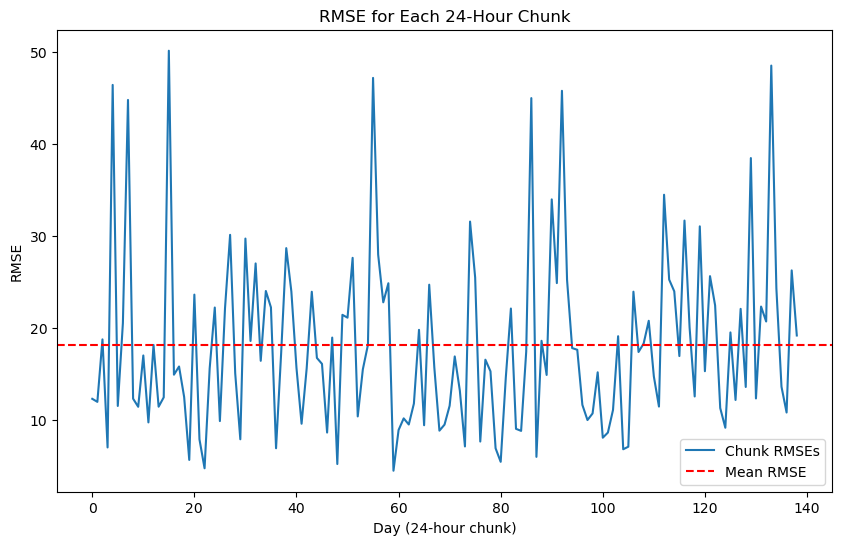

Percentage of targets within confidence intervals: 96.40%
RMSE considering confidence intervals: 2.6283
Mean Confidence Interval Size: 85.9617
Percentage of targets within confidence intervals: 96.40%
RMSE considering confidence intervals: 2.6283
Mean Confidence Interval Size: 85.9617
Mean Absolute Error: 14.1831
Correlation between Absolute Error and Confidence Interval Size: 0.1245


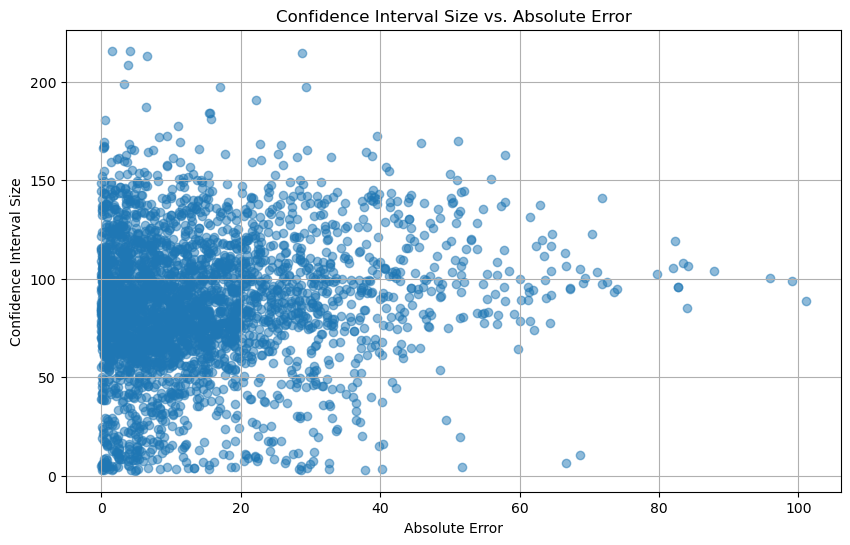

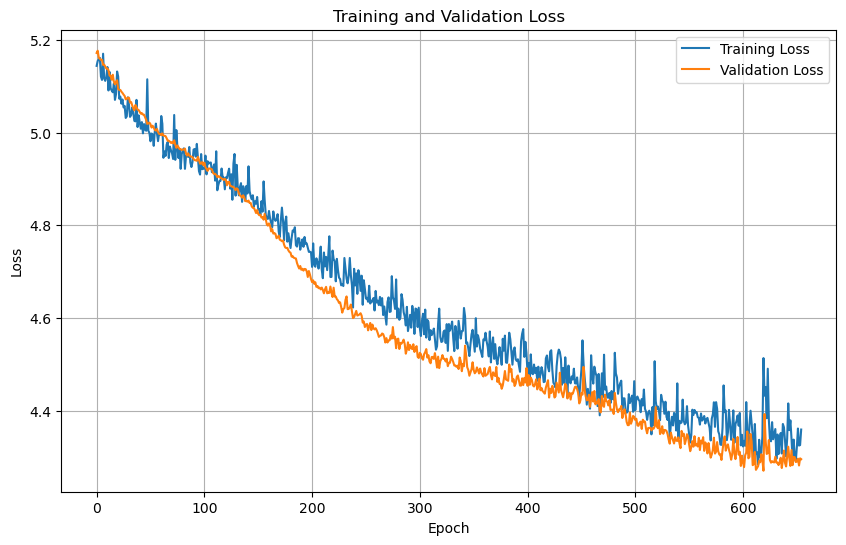

In [26]:
# Evaluate the model
model.eval()
forecasts, targets, scales = [], [], []

# Iterate through the test/validation loader
with torch.no_grad():
    for inputs, target in val_loader:
        loc, scale = model(inputs)
        forecasts.append(loc)
        targets.append(target)
        scales.append(scale)

# Flatten tensors
forecasts_flat = torch.cat(forecasts, axis=0)
targets_flat = torch.cat(targets, axis=0)
scales_flat = torch.cat(scales, axis=0)

# Compute RMSE for each sample in the test set
sample_rmse = torch.sqrt(torch.mean((forecasts_flat - targets_flat)**2, axis=1))

# Compute mean RMSE and standard deviation
mean_rmse = sample_rmse.mean().item()
std_rmse = sample_rmse.std().item()

# Print results
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Standard Deviation of RMSE: {std_rmse:.4f}")



# Number of hours in the validation dataset
val_hours = len(val_dataset) * 24
print(f"Number of hours in the test dataset: {val_hours}")


# Reshape into 24-hour chunks
forecasts_reshaped = forecasts_flat.view(-1, 24)
targets_reshaped = targets_flat.view(-1, 24)
scales_reshaped = scales_flat.view(-1, 24)

# Calculate RMSE for each 24-hour chunk
chunk_rmses = []
for i in range(forecasts_reshaped.shape[0]):
    mse_loss = nn.MSELoss()
    mse = mse_loss(forecasts_reshaped[i], targets_reshaped[i])
    rmse = torch.sqrt(mse).item()
    chunk_rmses.append(rmse)

# Compute overall statistics
mean_rmse = np.mean(chunk_rmses)
std_rmse = np.std(chunk_rmses)

# Print results
print(f"Mean RMSE over 24-hour chunks: {mean_rmse:.4f}")
print(f"Standard Deviation of RMSE over 24-hour chunks: {std_rmse:.4f}")

# Plot RMSE per chunk
plt.figure(figsize=(10, 6))
plt.plot(chunk_rmses, label="Chunk RMSEs")
plt.axhline(mean_rmse, color='r', linestyle='--', label='Mean RMSE')
plt.xlabel("Day (24-hour chunk)")
plt.ylabel("RMSE")
plt.title("RMSE for Each 24-Hour Chunk")
plt.legend()
plt.show()



# Define the 95% confidence intervals
lower_bounds = forecasts_flat - 1.96 * scales_flat
upper_bounds = forecasts_flat + 1.96 * scales_flat

# Check if targets are within the confidence intervals
within_interval = (targets_flat >= lower_bounds) & (targets_flat <= upper_bounds)
num_within_interval = within_interval.sum().item()
accuracy_within_interval = num_within_interval / targets_flat.numel() * 100

# Initialize errors tensor
errors = torch.zeros_like(targets_flat)

# Calculate errors for each prediction
for i in range(len(targets_flat)):
    for j in range(targets_flat.shape[1]):  # Iterate over 24-hour chunks
        if within_interval[i, j].item():  # Convert each element to a scalar boolean
            errors[i, j] = 0  # No error if within confidence interval
        else:
            # Error is the distance to the nearest bound
            if targets_flat[i, j] < lower_bounds[i, j]:
                errors[i, j] = lower_bounds[i, j] - targets_flat[i, j]
            elif targets_flat[i, j] > upper_bounds[i, j]:
                errors[i, j] = targets_flat[i, j] - upper_bounds[i, j]

# Compute RMSE considering the confidence intervals
rmse_with_intervals = torch.sqrt(torch.mean(errors**2)).item()

# Print results
print(f"Percentage of targets within confidence intervals: {accuracy_within_interval:.2f}%")
print(f"RMSE considering confidence intervals: {rmse_with_intervals:.4f}")


# Define the 95% confidence intervals
lower_bounds = forecasts_flat - 1.96 * scales_flat
upper_bounds = forecasts_flat + 1.96 * scales_flat

# Compute the mean confidence interval size
confidence_interval_sizes = upper_bounds - lower_bounds
mean_confidence_interval_size = torch.mean(confidence_interval_sizes).item()

# Check if targets are within the confidence intervals
within_interval = (targets_flat >= lower_bounds) & (targets_flat <= upper_bounds)
num_within_interval = within_interval.sum().item()
accuracy_within_interval = num_within_interval / targets_flat.numel() * 100

# Initialize errors tensor
errors = torch.zeros_like(targets_flat)

# Calculate errors for each prediction
for i in range(len(targets_flat)):
    for j in range(targets_flat.shape[1]):  # Iterate over 24-hour chunks
        if within_interval[i, j].item():  # Convert each element to a scalar boolean
            errors[i, j] = 0  # No error if within confidence interval
        else:
            # Error is the distance to the nearest bound
            if targets_flat[i, j] < lower_bounds[i, j]:
                errors[i, j] = lower_bounds[i, j] - targets_flat[i, j]
            elif targets_flat[i, j] > upper_bounds[i, j]:
                errors[i, j] = targets_flat[i, j] - upper_bounds[i, j]

# Compute RMSE considering the confidence intervals
rmse_with_intervals = torch.sqrt(torch.mean(errors**2)).item()

# Print results
print(f"Mean Confidence Interval Size: {mean_confidence_interval_size:.4f}")
print(f"Percentage of targets within confidence intervals: {accuracy_within_interval:.2f}%")
print(f"RMSE considering confidence intervals: {rmse_with_intervals:.4f}")


# Define the 95% confidence intervals
lower_bounds = forecasts_flat - 1.96 * scales_flat
upper_bounds = forecasts_flat + 1.96 * scales_flat

# Flatten the tensors to ensure they are 1-dimensional
absolute_errors_flat = absolute_errors.view(-1)
confidence_interval_sizes_flat = confidence_interval_sizes.view(-1)

# Compute correlation between absolute error and confidence interval size
correlation = torch.corrcoef(torch.stack([absolute_errors_flat, confidence_interval_sizes_flat]))[0, 1].item()

# Print results
print(f"Mean Confidence Interval Size: {mean_confidence_interval_size:.4f}")
print(f"Mean Absolute Error: {mean_absolute_error:.4f}")
print(f"Correlation between Absolute Error and Confidence Interval Size: {correlation:.4f}")

# Visualize the relationship between absolute error and confidence interval size
plt.figure(figsize=(10, 6))
plt.scatter(absolute_errors_flat.cpu().numpy(), confidence_interval_sizes_flat.cpu().numpy(), alpha=0.5)
plt.title("Confidence Interval Size vs. Absolute Error")
plt.xlabel("Absolute Error")
plt.ylabel("Confidence Interval Size")
plt.grid()
plt.show()


# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses[100:], label="Training Loss")
plt.plot(val_losses[100:], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()




